In [1]:
import yaml
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

import shapely.geometry as geo
import descartes as des

from IPython.display import display, HTML, clear_output, Markdown, Image, Javascript
import ipywidgets as widgets

from bokeh.io import output_notebook
from bokeh.plotting import show
output_notebook()

from plotly import offline
from plotly import plotly
from plotly import graph_objs
from plotly import tools
offline.init_notebook_mode()

from electroninserts import (
    shapely_insert, display_shapely, display_parameterisation, shapely_ellipse,
    interactive, convert2_ratio_perim_area, spline_model, calculate_deformability,
    create_native_mesh, create_transformed_mesh
)

# from electroninserts import (
#     create_green_cm, display_shapely, shapely_cutout, shapely_ellipse,
#     create_model, fit_give, to_eqPonA)
# green_cm = create_green_cm()

from matplotlib import rc
rc('font',**{'family':'serif',
             'size':'16'})

rc('legend', fontsize=12)

Loading BokehJS ...

In [2]:
# display(Javascript('<script src="https://cdn.plot.ly/plotly-latest.min.js"></script>'))

In [3]:


# z = np.array([[2, 4, 7, 12, 13, 14, 15, 16],
#        [3, 1, 6, 11, 12, 13, 16, 17],
#        [4, 2, 7, 7, 11, 14, 17, 18],
#        [5, 3, 8, 8, 13, 15, 18, 19],
#        [7, 4, 10, 9, 16, 18, 20, 19],
#        [9, 10, 5, 27, 23, 21, 21, 21],
#        [11, 14, 17, 26, 25, 24, 23, 22]])

# text = ["{}</br>{}".format(item,item+1) for item in np.ravel(z)]
# text = np.reshape(text, np.shape(z))

# trace0 = graph_objs.Contour(
#     z=z,
#     text=text,
#     colorscale='Viridis',
#     line=dict(smoothing=0),
# )
# trace1 = graph_objs.Contour(
#     z=z,
#     colorscale='Viridis',
#     line=dict(smoothing=0.85),
# )

# fig = tools.make_subplots(rows=1, cols=2,
#                           subplot_titles=('Without Smoothing', 'With Smoothing'))

# fig.append_trace(trace0, 1, 1)
# fig.append_trace(trace1, 1, 2)

In [4]:
# offline.iplot(fig)

In [26]:
# import warnings

# warnings.simplefilter("ignore")

select_height = '23em'
select_width = '15em'

# Spline modelling electron cutout factors using routine measurements

 * **Simon Biggs**
 * Matthew Sobolewski
 * Rebecca Murry
 * John Kenny

# Overview

 * Interpolate between electron factors of irregular shapes
 * Interpolation between data many clinics already have
 * To an uncertainty that approaches measurement
 * With just eight measurements can predict to 0.5% uncertainty
 * Many centres directly measure this factor*

*[AAPM TG 71](http://dx.doi.org/10.1118/1.4864244)

# Contributions to the cutout factor

 * Lateral scatter to $d_{max}$ [width]
 * Shielding leakage (1-2%)\* [1/area]
 * Internal surface scatter (1-2%)\* [perimeter]

*[Faddegon, Villarreal-Barajas. Med Phys 2005.](http://dx.doi.org/10.1118/1.2068947)

![](presentation_resources/collimator_and_shielding_effects.svg)

# Method overview

![](presentation_resources/flow_diagram.png)

In [6]:
with open("presentation_resources/12MeV_10app_100ssd.yml", 'r') as file:
    insert_data = yaml.load(file)
    
label = np.sort([key for key in insert_data])

# A series of measured inserts

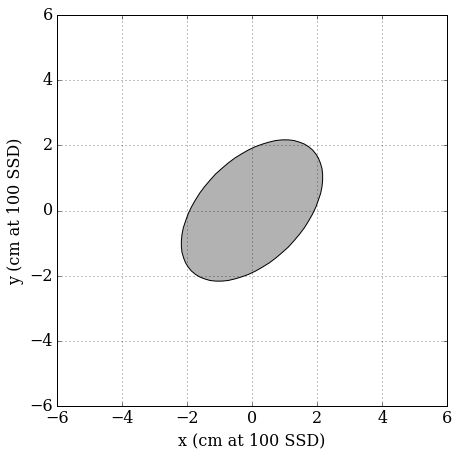

 > Cutout factor = 0.9348

In [29]:
select_for_initial_display = widgets.Select(
    options=list(label),
    height=select_height,
    width=select_width
)

display(select_for_initial_display)

def initial_display_on_change(_):
    clear_output(wait=True)
    key = select_for_initial_display.value
    
    insert = shapely_insert(
        insert_data[key]['XCoords'],
        insert_data[key]['YCoords']
    )
    
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)

    display_shapely(ax, insert, alpha=0.3)

    ax.set_xlim([-6,6])
    ax.set_ylim([-6,6])
    ax.set_xlabel('x (cm at 100 SSD)')
    ax.set_ylabel('y (cm at 100 SSD)')
    plt.grid(True)
    plt.show(fig)
    display(Markdown(" > Cutout factor = {}".format(insert_data[key]['factor'])))


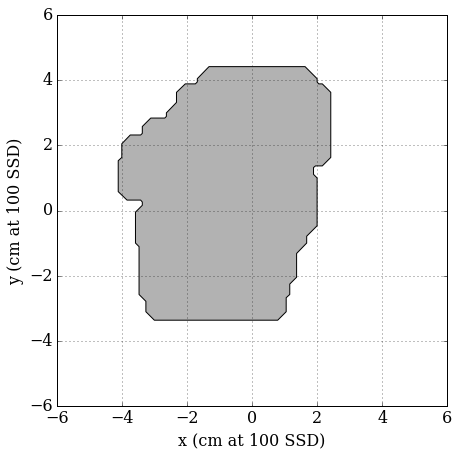

 > Cutout factor = 0.9934

In [30]:
initial_display_on_change(_)
select_for_initial_display.observe(initial_display_on_change, 'value')

# Calculating width
 * Diameter of largest circle encompassed by cutout

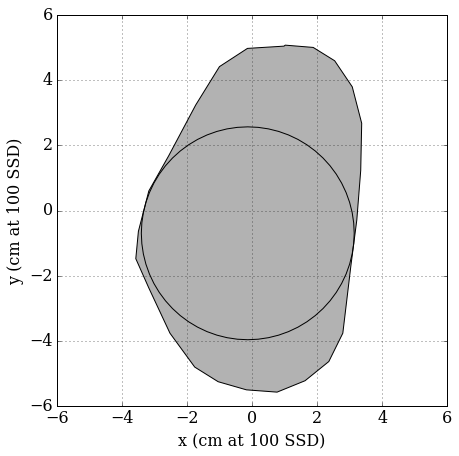

 > Width = 6.5 cm at 100 SSD

In [27]:
select_for_show_width = widgets.Select(
    options=list(label),
    height=select_height,
    width=select_width
)

display(select_for_show_width)

def show_width_on_change(_):
    
    clear_output(wait=True)
    key = select_for_show_width.value
    
    insert = shapely_insert(
        insert_data[key]['XCoords'],
        insert_data[key]['YCoords']
    )
    
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)

    poi = insert_data[key]['poi']    
    width = insert_data[key]['width']
    circle = geo.Point(*poi).buffer(width/2)
    
    display_shapely(ax, insert, alpha=0.3)
    display_shapely(ax, circle, alpha=0)
    
    ax.set_xlim([-6,6])
    ax.set_ylim([-6,6])
    ax.set_xlabel('x (cm at 100 SSD)')
    ax.set_ylabel('y (cm at 100 SSD)')
    plt.grid(True)
    plt.show(fig)
    display(Markdown(
            " > Width = {0:.1f} cm at 100 SSD".format(
                insert_data[key]['width'])))
    
show_width_on_change(_)
select_for_show_width.observe(show_width_on_change, 'value')

# Calculating length
 * Length such that ellipse has equal area to cutout

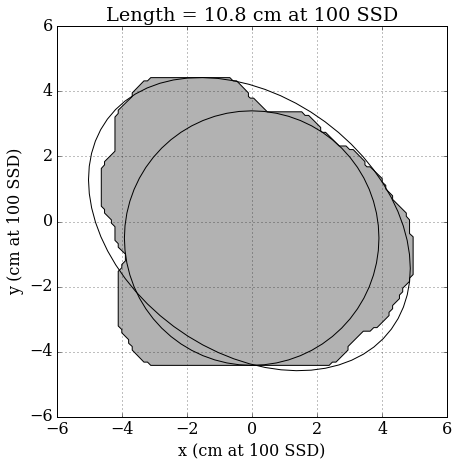

In [38]:
select_for_show_ellipse = widgets.Select(
    options=list(label),
    height='10em'
)

display(select_for_show_ellipse)

def show_ellipse_on_change(_):
    clear_output(wait=True)
    
    key = select_for_show_ellipse.value
    
    insert = shapely_insert(
        insert_data[key]['XCoords'],
        insert_data[key]['YCoords'])
    
    poi = insert_data[key]['poi']    
    width = insert_data[key]['width']
    circle = geo.Point(*poi).buffer(width/2)
    
    mid = insert_data[key]['mid']
    angle = insert_data[key]['angle']
    
    width = insert_data[key]['width']
    length = insert_data[key]['length']
    ellipse = shapely_ellipse(
            mid[0], mid[1],
            width, length,
            angle)
    
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    
    display_shapely(ax, insert, alpha=0.3)
    display_shapely(ax, circle, alpha=0)
    display_shapely(ax, ellipse, alpha=0)
    
    ax.set_xlim([-6,6])
    ax.set_ylim([-6,6])
    ax.set_xlabel('x (cm at 100 SSD)')
    ax.set_ylabel('y (cm at 100 SSD)')
    plt.grid(True)
    
    ax.set_title("Length = {0:.1f} cm at 100 SSD".format(length))

    plt.show(fig)
    
show_ellipse_on_change(_)
select_for_show_ellipse.observe(show_ellipse_on_change, 'value')

# Smoothing bivariate spline

In [10]:
width = np.array([
        insert_data[key]['width']
        for key in label
    ])
length = np.array([
        insert_data[key]['length']
        for key in label
    ])

ratio_perim_area = convert2_ratio_perim_area(width, length)

factor = np.array([
        insert_data[key]['factor']
        for key in label
    ])

show(interactive(width, length, ratio_perim_area, factor, label))

In [11]:
xx, yy, zz = create_native_mesh(width, ratio_perim_area, factor)

vmin = 0.92
vmax = 1.01

data = []

data += [
    graph_objs.Surface(
        x=xx,
        y=yy,
        z=zz,
        colorscale='Viridis',
        cauto=False,
        zmin=vmin,
        zmax=vmax)]

data += [
    graph_objs.Scatter3d(
        x=width,
        y=ratio_perim_area,
        z=factor, 
        mode='markers', 
        marker=dict(
            size=5,
            color=factor,
            colorscale='Viridis',
            opacity=1,
            cmin=vmin,
            cmax=vmax,
            line=dict(
                color='black',
                width=1)))]

layout = graph_objs.Layout(
    title='Reference Spline Interpolation',
    autosize=False,
    width=700,
    height=600,
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )
)

fig = graph_objs.Figure(data=data, layout=layout)
offline.iplot(fig)

In [12]:
def plotly_transformed(width, length, factor):
    xx, yy, zz = create_transformed_mesh(width, length, factor)

    vmin = 0.92
    vmax = 1.01

    data = []

    data += [
        graph_objs.Surface(
            x=xx,
            y=yy,
            z=zz,
            colorscale='Viridis',
            cauto=False,
            zmin=vmin,
            zmax=vmax)]

    data += [
        graph_objs.Scatter3d(
            x=width,
            y=length,
            z=factor, 
            mode='markers', 
            marker=dict(
                size=5,
                color=factor,
                colorscale='Viridis',
                opacity=1,
                cmin=vmin,
                cmax=vmax,       
                line=dict(
                    color='black',
                    width=1)))]

    layout = graph_objs.Layout(
        title='Reference Spline Interpolation',
        autosize=False,
        width=700,
        height=600,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )

    fig = graph_objs.Figure(data=data, layout=layout)
    offline.iplot(fig)
    
plotly_transformed(width, length, factor)

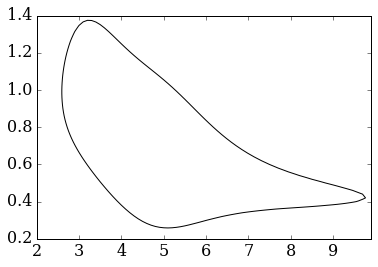

In [13]:
x = np.arange(
    2.5,
    9.91, 0.6)
y = np.arange(
    0.2,
    1.41, 0.12)

xx, yy = np.meshgrid(x, y)

zz = spline_model(xx, yy, width, ratio_perim_area, factor)


def find_deformability_contour():
    x = np.arange(
        np.floor(np.min(width)) - 1,
        np.ceil(np.max(width)), 0.1)
    y = np.arange(
        np.floor(np.min(ratio_perim_area)*10)/10 - 0.2,
        np.ceil(np.max(ratio_perim_area)*10)/10 + 0.1, 0.02)

    xx, yy = np.meshgrid(x, y)
    deformability = calculate_deformability(xx, yy, width, ratio_perim_area, factor)
    
    cs = plt.contour(xx, yy, deformability, levels=[0.5], colors='k');
    
    p = cs.collections[0].get_paths()[0]
    v = p.vertices
    x = v[:,0]
    y = v[:,1]
    z = spline_model(x, y, width, ratio_perim_area, factor)
    
    return x, y, z


deformability_x, deformability_y, deformability_z = find_deformability_contour()

circle_bound_width = np.linspace(2.9, 9.7)
circle_bound_eqPonA = convert2_ratio_perim_area(circle_bound_width, circle_bound_width)
circle_bound_factor = spline_model(
    circle_bound_width, circle_bound_eqPonA, 
    width, ratio_perim_area, factor)

max_eqPonA_width = np.linspace(2.5, 9.7)
max_area = (
    (10 * np.sqrt(2) - max_eqPonA_width) * 
    max_eqPonA_width + (max_eqPonA_width/np.sqrt(2))**2)
max_length = 4 * max_area / (np.pi * max_eqPonA_width)
max_eqPonA = convert2_ratio_perim_area(max_eqPonA_width, max_length)
max_factor = spline_model(
    max_eqPonA_width, max_eqPonA,
    width, ratio_perim_area, factor)

In [14]:
def spline_3d(elevation, azimuth):

    
    fig = plt.figure(figsize=(10/.9, 1*(10/1.618)))
    ax = fig.add_subplot(111, projection='3d', axisbg=(1,1,1,0))
    
    fig.subplots_adjust(right=0.90)
    cbar_ax = fig.add_axes([0.90, 0.125, 0.025, 0.775])    
    
    vmin = 0.92
    vmax = 1.015
    
    ax.plot_surface(
        xx, yy, zz, vmin=vmin, vmax=vmax, 
        cmap='viridis', linewidth=0, antialiased=False,
        rstride=1, cstride=1, alpha=1)
    
    norm = Normalize(vmin=vmin, vmax=vmax)

    cb = ColorbarBase(
        cbar_ax, cmap='viridis', alpha=1,
        norm=norm, label=r'Cutout factor')
    
    ax.plot(
        width, ratio_perim_area, factor, 'go', ms=10, alpha=1,
        label='Measured factors', mew=1.5)
    
    ax.plot(
        deformability_x, deformability_y, deformability_z, 'k',
        label='Deformability boundary')
    ax.plot(
        circle_bound_width, circle_bound_eqPonA, 
        circle_bound_factor, 'k', lw=3, 
        label='Circle bound')
    ax.plot(
        max_eqPonA_width, max_eqPonA, 
        max_factor, 'k--', lw=3, 
        label='Approx. applicator bound')
    
    ax.view_init(elev=elevation, azim=azimuth)
    
    ax.set_xlabel('Width (cm)')
    ax.set_ylabel('Perimeter / Area (cm^-1)')
    ax.set_zlabel('Insert factor')
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, ncol=2, numpoints=3)
    
    ax.set_xlim([2.5, 9.9])
    ax.set_ylim([0.2, 1.4])


C:\Users\sbiggs\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: DeprecationWarning:

on_trait_change is deprecated: use observe instead

C:\Users\sbiggs\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: DeprecationWarning:

on_trait_change is deprecated: use observe instead



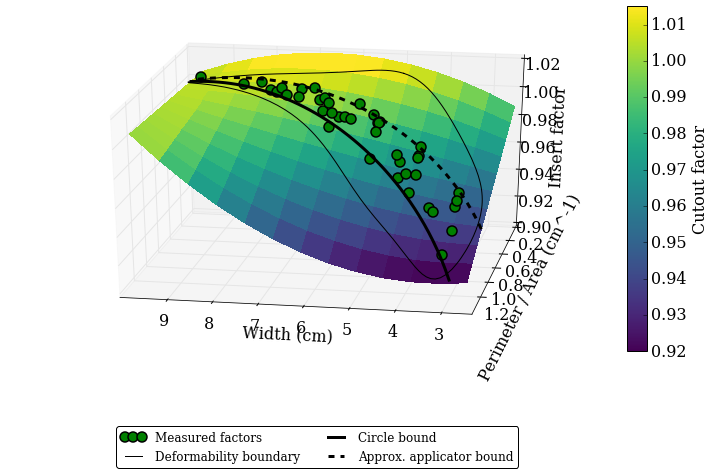

In [15]:
elevation_slider = widgets.IntSlider(
    min=0, max=90, step=5, value=25, 
    description='Elevation . ', orientation='vertical')
azimuth_slider = widgets.IntSlider(
    min=-190, max=190, step=10, value=100, 
    description='. Azimuth', orientation='vertical')

container = widgets.HBox(children=[elevation_slider, azimuth_slider])
display(container)

def on_slider_change():
    if azimuth_slider.value == 190:
        azimuth_slider.value = -170
    elif azimuth_slider.value == -190:
        azimuth_slider.value = 170
    else: 
        clear_output(wait=True)
        azimuth = azimuth_slider.value
        elevation = elevation_slider.value

        spline_3d(elevation, azimuth)
    

on_slider_change()
elevation_slider.on_trait_change(on_slider_change, 'value')    
azimuth_slider.on_trait_change(on_slider_change, 'value')

# Producing the spline

In [16]:
def display_spline(width, length, factor):
    perimeter = (
        np.pi / 2 * 
        (3*(width + length) - 
         np.sqrt((3*width + length)*(3*length + width))))
    area = np.pi / 4 * width * length
    eqPonA = perimeter / area
    
    model = create_model(width, eqPonA, factor)
    
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(7, 2*(7/1.618)))

    fig.subplots_adjust(right=0.80)
    cbar_ax = fig.add_axes([0.85, 0.125, 0.04, 0.775])
    
    x = np.arange(
        np.floor(np.min(width)) - 1,
        np.ceil(np.max(width)), 0.1)
    y = np.arange(
        np.floor(np.min(eqPonA)*10)/10 - 0.2,
        np.ceil(np.max(eqPonA)*10)/10 + 0.1, 0.02)

    xx, yy = np.meshgrid(x, y)

    zz = model(xx, yy)
    give_contour = fit_give(xx, yy, width, eqPonA, factor, kx=2, ky=1)

    maximum_eqPonA = to_eqPonA(xx, xx)

    mesh_max_area = ((10 * np.sqrt(2) - xx) * xx + (xx/np.sqrt(2))**2)
    mesh_max_length = 4 * mesh_max_area / (np.pi * xx)

    minimum_rqPonA = to_eqPonA(xx, mesh_max_length)

    full_colour = give_contour < 0.5

    full_colour_zz = zz.copy()
    full_colour_zz[~full_colour] = np.nan
    
    vmin = 0.92
    vmax = 1.015

    circle_bound_width = np.linspace(2, 10)
    circle_bound_eqPonA = to_eqPonA(circle_bound_width, circle_bound_width)

    max_eqPonA_width = np.linspace(2, 10)
    max_area = (
        (10 * np.sqrt(2) - max_eqPonA_width) * 
        max_eqPonA_width + (max_eqPonA_width/np.sqrt(2))**2)
    max_length = 4 * max_area / (np.pi * max_eqPonA_width)
    max_eqPonA = to_eqPonA(max_eqPonA_width, max_length)

    ax1.contourf(
        xx, yy, full_colour_zz, 40, alpha=1, 
        cmap=green_cm, vmin=vmin, vmax=vmax)
    ax1.contour(
        xx, yy, full_colour_zz, 40, alpha=1, 
        cmap=green_cm, vmin=vmin, vmax=vmax)

    norm = Normalize(vmin=vmin, vmax=vmax)

    cb = ColorbarBase(
        cbar_ax, cmap=green_cm, alpha=1,
        norm=norm, label=r'Cutout factor')

    ax1.scatter(
        width, eqPonA, s=150, lw=2,
        c=factor, cmap=green_cm, 
        vmin=vmin, vmax=vmax,
        zorder=100)

    ax1.scatter(
        [-1]*3, [-1]*3, s=150, lw=2,
        c=[green_cm(0.2), green_cm(0.5), green_cm(0.8)],
        zorder=100, 
        label='Measured 12 MeV data')

    ax1.contour(xx, yy, give_contour, levels=[0.5], colors='k')
    ax1.plot(3, 0.4, 'k-', label='Deformability boundary')

    ax1.plot(
        circle_bound_width, circle_bound_eqPonA, 
        'k', lw=3, label='Circle bound', zorder=99)
    ax1.plot(
        max_eqPonA_width, max_eqPonA, 'k--', 
        lw=3, label='Approx. applicator bound', zorder=99)

    ax1.set_xlabel('Width (cm)')
    ax1.set_ylabel('Perimeter / Area (cm$^{-1}$)')
    ax1.set_xlim([2.4, 9.8])
    ax1.set_ylim([0.36, 1.4])

    tk_all = ax1.get_xticklabels()
    for tk in tk_all:
        tk.set_visible(True)
        
        
    x = np.arange(2.5, 10, 0.1)
    y = np.arange(2.5, 18, 0.2)

    mesh_width, mesh_length = np.meshgrid(x, y)

    mesh_eqPonA = to_eqPonA(mesh_width, mesh_length)

    width_length_zz = model(mesh_width, mesh_eqPonA)
    give = fit_give(mesh_width, mesh_eqPonA, width, eqPonA, factor, kx=2, ky=1)


    mesh_max_area = (
        (10 * np.sqrt(2) - mesh_width) * 
        mesh_width + (mesh_width/np.sqrt(2))**2)
    mesh_max_length = 4 * mesh_max_area / (np.pi * mesh_width)

    full_colour = give < 0.5

    full_colour_width_length_zz = width_length_zz.copy()
    full_colour_width_length_zz[~full_colour] = np.nan

    circle_bound_width = np.linspace(2, 11)

    max_length_width = np.linspace(2, 11)
    max_area = (
        (10 * np.sqrt(2) - max_length_width) * 
        max_length_width + (max_length_width/np.sqrt(2))**2)
    max_length = 4 * max_area / (np.pi * max_length_width)

    c = ax2.contourf(mesh_width, mesh_length, full_colour_width_length_zz, 40, 
                     alpha=1, cmap=green_cm, vmin=vmin, vmax=vmax)
    ax2.contour(mesh_width, mesh_length, full_colour_width_length_zz, 40, 
                     alpha=1, cmap=green_cm, vmin=vmin, vmax=vmax)

    ax2.scatter(
        width, length, s=150, lw=2,
        c=factor, cmap=green_cm, 
        vmin=vmin, vmax=vmax,
        zorder=3)

    ax2.scatter(
        [-1]*3, [-1]*3, s=150, lw=2,
        c=[green_cm(0.2), green_cm(0.5), green_cm(0.8)],
        zorder=3, 
        label='Measured 12 MeV data')

    ax2.contour(mesh_width, mesh_length, give, levels=[0.5], colors='k')
    ax2.plot(3, 0.4, 'k-', label='Deformability boundary')

    ax2.plot(
        circle_bound_width, circle_bound_width, 
        'k', lw=3, label='Circle bound', zorder=2)
    ax2.plot(
        max_length_width, max_length, 
        'k--', lw=3, label='Approx. applicator bound', zorder=2)

    ax2.set_xlabel('Width (cm)')
    ax2.set_ylabel('Length (cm)')
    ax2.set_xlim([2.4, 9.8])
    ax2.set_ylim([2, 14])

    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
              fancybox=True, ncol=2)

In [17]:
select_for_spline = widgets.SelectMultiple(
    options=list(label),
    height=select_height,
    width='12em',
    value=(
        'Simon #32 cutout', 
        'Simon 3cm circle',
        'Simon 3x13cm oval',
        'Simon 4cm circle',
        'Simon 5cm circle',
        'Simon 5x13cm oval',
        'Simon 7cm circle',
        'Simon 9cm circle'        
    )
)

button_calculate_spline = widgets.Button(
    description="Calculate",
    width='13em')

button_default_spline = widgets.Button(
    description="Default",
    width='13em')

display(select_for_spline, button_calculate_spline, button_default_spline)

def on_button_clicked_spline(b):
    clear_output(wait=True)
    
    if len(select_for_spline.value) < 8:
        raise Exception("Need at least 8 data points for spline")
    
    width = np.array([
            cutout_data[key]['width']
            for key in select_for_spline.value
        ])
    length = np.array([
            cutout_data[key]['length']
            for key in select_for_spline.value
        ])
    factor = np.array([
            cutout_data[key]['factor']
            for key in select_for_spline.value
        ])
    
    display_spline(width, length, factor)

def default_button_spline(b):
    select_for_spline.value = (
        'Simon #32 cutout', 
        'Simon 3cm circle',
        'Simon 3x13cm oval',
        'Simon 4cm circle',
        'Simon 5cm circle',
        'Simon 5x13cm oval',
        'Simon 7cm circle',
        'Simon 9cm circle'        
    )
    
    on_button_clicked_spline(0)
    
on_button_clicked_spline(0)
button_calculate_spline.on_click(on_button_clicked_spline)
button_default_spline.on_click(default_button_spline)

TraitError: Invalid selection

# Where to measure for optimum coverage

In [ ]:
display(Image(filename="where_to_measure.png"))

# Model validation

In [ ]:
def colour(x, alpha=1):
    result = list(green_cm(x))
    result[3] = alpha
    
    return result

def display_prediction_differences(label_model):
    width = np.array([
            cutout_data[key]['width']
            for key in label_model
        ])
    length = np.array([
            cutout_data[key]['length']
            for key in label_model
        ])
    factor = np.array([
            cutout_data[key]['factor']
            for key in label_model
        ])
    
    perimeter = (
        np.pi / 2 * 
        (3*(width + length) - 
         np.sqrt((3*width + length)*(3*length + width))))
    area = np.pi / 4 * width * length
    eqPonA = perimeter / area
    
    model = create_model(width, eqPonA, factor)
    
    
    label_not_modelled = np.setdiff1d(label, label_model)
    
    width_not_modelled = np.array([
            cutout_data[key]['width']
            for key in label_not_modelled
        ])
    length_not_modelled = np.array([
            cutout_data[key]['length']
            for key in label_not_modelled
        ])
    factor_not_modelled = np.array([
            cutout_data[key]['factor']
            for key in label_not_modelled
        ])
    
    perimeter_not_modelled = (
        np.pi / 2 * 
        (3*(width_not_modelled + length_not_modelled) - 
         np.sqrt((3*width_not_modelled + length_not_modelled)*(3*length_not_modelled + width_not_modelled))))
    area_not_modelled = np.pi / 4 * width_not_modelled * length_not_modelled
    eqPonA_not_modelled = perimeter_not_modelled / area_not_modelled
    
    give_points = fit_give(
        width_not_modelled, eqPonA_not_modelled, width, eqPonA, factor, kx=2, ky=1)
    valid_points = give_points < 0.5
    
    valid_predictions = model(
        width_not_modelled[valid_points], eqPonA_not_modelled[valid_points])
    prediction_differences = 100 * (
        (factor_not_modelled[valid_points] - valid_predictions) / 
        factor_not_modelled[valid_points])

    
    vmin = 0.92
    vmax = 1.015
    
    
    
    fig, ax2 = plt.subplots(1, sharex=True, figsize=(7, (7/1.618)))

    fig.subplots_adjust(right=0.80)
    cbar_ax = fig.add_axes([0.85, 0.125, 0.04, 0.775])        
        
    x = np.arange(2.5, 10, 0.1)
    y = np.arange(2.5, 18, 0.2)

    mesh_width, mesh_length = np.meshgrid(x, y)

    mesh_eqPonA = to_eqPonA(mesh_width, mesh_length)

    width_length_zz = model(mesh_width, mesh_eqPonA)
    give = fit_give(mesh_width, mesh_eqPonA, width, eqPonA, factor, kx=2, ky=1)


    mesh_max_area = (
        (10 * np.sqrt(2) - mesh_width) * 
        mesh_width + (mesh_width/np.sqrt(2))**2)
    mesh_max_length = 4 * mesh_max_area / (np.pi * mesh_width)

    full_colour = give < 0.5

    full_colour_width_length_zz = width_length_zz.copy()
    full_colour_width_length_zz[~full_colour] = np.nan

    circle_bound_width = np.linspace(2, 11)

    max_length_width = np.linspace(2, 11)
    max_area = (
        (10 * np.sqrt(2) - max_length_width) * 
        max_length_width + (max_length_width/np.sqrt(2))**2)
    max_length = 4 * max_area / (np.pi * max_length_width)

    c = ax2.contourf(mesh_width, mesh_length, full_colour_width_length_zz, 40, 
                     alpha=1, cmap=green_cm, vmin=vmin, vmax=vmax)
    ax2.contour(mesh_width, mesh_length, full_colour_width_length_zz, 40, 
                     alpha=1, cmap=green_cm, vmin=vmin, vmax=vmax)

    ax2.scatter(
        width, length, s=150, lw=1.5,
        c=(0.2,0.2,0.2,1), 
        vmin=vmin, vmax=vmax,
        zorder=3)

    ax2.scatter(
        [-1]*3, [-1]*3, s=150, lw=1.5,
        c=(0.2,0.2,0.2,1),
        zorder=3, 
        label='Used to make spline')
    
    
    ax2.scatter(
        width_not_modelled[valid_points], length_not_modelled[valid_points], 
        s=150, lw=1.5, c=(0.2,0.9,0.2,1), 
        vmin=vmin, vmax=vmax,
        zorder=3)

    ax2.scatter(
        [-1]*3, [-1]*3, s=150, lw=1.5, c=(0.2,0.9,0.2,1),
        zorder=3, 
        label='Within valid region')
    
    
    ax2.scatter(
        width_not_modelled[~valid_points], length_not_modelled[~valid_points], 
        s=150, lw=1.5, c=(1,0.4,0.4,1),
        vmin=vmin, vmax=vmax,
        zorder=3)

    ax2.scatter(
        [-1]*3, [-1]*3, s=150, lw=1.5, c=(1,0.4,0.4,1),
        zorder=3, 
        label='Outside valid region')
    

    ax2.contour(mesh_width, mesh_length, give, levels=[0.5], colors='k')
    ax2.plot(3, 0.4, 'k-')

    ax2.plot(
        circle_bound_width, circle_bound_width, 
        'k', lw=3, zorder=2)
    ax2.plot(
        max_length_width, max_length, 
        'k--', lw=3, zorder=2)

    ax2.set_xlabel('Width (cm)')
    ax2.set_ylabel('Length (cm)')
    ax2.set_xlim([2.4, 9.8])
    ax2.set_ylim([2, 14])

    legend = ax2.legend(fancybox=True, loc='lower right')
    legend.get_frame().set_facecolor([1,1,1,0.5])
    
    norm = Normalize(vmin=vmin, vmax=vmax)

    cb = ColorbarBase(
        cbar_ax, cmap=green_cm, alpha=1,
        norm=norm, label=r'Insert factor')
    
    plt.figure(figsize=(7, (7/1.618)))

    bins = np.arange(-2.0, 2.01, 1/3)
    dbins = bins[1] - bins[0]
    binsTrans = bins - dbins/2

    binsTrans = binsTrans.reshape(-1,1)
    binNum = np.argmin(abs(binsTrans - prediction_differences),0)

    representative_height = np.zeros(len(binNum))

    for i in range(len(bins)):
        binRef = (binNum == i)
        representative_height[binRef] = np.arange(sum(binRef)) + 1
    
    plt.hist(
        prediction_differences, bins, 
        fc=colour(0.6), lw=1)
    plt.scatter(
        prediction_differences, 
        representative_height, zorder=2, 
        s=150, lw=1.5, edgecolor='black', c=(0.2,0.9,0.2,1))
    
    plt.xlim([-2,2])
    
    plt.xlabel(
        '% Prediction Difference '
        '$\\left[100 \\times \\frac{measured - predicted}{measured}\\right]$')
    plt.ylabel('Frequency')

In [ ]:
select_for_prediction_diffs = widgets.SelectMultiple(
    options=list(label),
    height=select_height,
    width='12em',
    value=(
        'Simon #32 cutout', 
        'Simon 3cm circle',
        'Simon 3x13cm oval',
        'Simon 4cm circle',
        'Simon 5cm circle',
        'Simon 5x13cm oval',
        'Simon 7cm circle',
        'Simon 9cm circle'        
    )
)

button_calculate_prediction_diffs = widgets.Button(
    description="Calculate",
    width='13em')

button_default_prediction_diffs = widgets.Button(
    description="Default",
    width='13em')

display(select_for_prediction_diffs, button_calculate_prediction_diffs, button_default_prediction_diffs)

def on_button_clicked_prediction_diffs(b):
    clear_output(wait=True)
    label_model = select_for_prediction_diffs.value
    
    if len(label_model) < 8:
        raise Exception("Need at least 8 data points for spline")    
    
    display_prediction_differences(label_model)

def default_button_prediction_diffs(b):
    select_for_prediction_diffs.value = (
        'Simon #32 cutout', 
        'Simon 3cm circle',
        'Simon 3x13cm oval',
        'Simon 4cm circle',
        'Simon 5cm circle',
        'Simon 5x13cm oval',
        'Simon 7cm circle',
        'Simon 9cm circle'        
    )
    
    on_button_clicked_prediction_diffs(0)
    
on_button_clicked_prediction_diffs(0)
button_calculate_prediction_diffs.on_click(on_button_clicked_prediction_diffs)
button_default_prediction_diffs.on_click(default_button_prediction_diffs)

In [ ]:
# %%HTML
# <style>
# #leftcol {
#     float: left;
#     width: 47%;
# }
# #rightcol {
#     float: right;
#     width: 47%;
# }
# </style>

# Uncertainty and outliers

<div>
    <div id="leftcol"><img src="prediction_difference_histogram.png"></div>
    <div id="rightcol"><img src="change_with_number_measurements.png"></div>
    <div id="cleared"></div>
</div>

# Overview of results

 * 12 MeV validation data had a predicition uncertainty of 0.4%
 * For 6, 9, 15, and 18 MeV the maximum recorded deviations were 0.8%, 0.8%, 0.9%, and 1.0%
 * One may expect an approximate uncertainty of 0.5% when as little as 8 data points are used
 * In 10$^6$ predictions no random subset of 8 datapoints produced a prediction difference greater than 2%

# Conclusion

 * A method that is easy to impliment
 * Uncertainty approaching measurement
 * Builds upon the vast amount of data already available
 * The level of accuracy combined with the ease with which this model can be generated demonstrates its suitability for clinical use
 * DOI of paper: [10.1016/j.ejmp.2015.11.002](http://dx.doi.org/10.1016/j.ejmp.2015.11.002)
 * Code available at: [github.com/SimonBiggs/electronfactors](https://github.com/SimonBiggs/electronfactors)
 * Feel free to contact me: [mail@simonbiggs.net](mailto:mail@simonbiggs.net)